## Loading libraries and data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os,gc

from math import sqrt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

from xgboost import XGBRegressor

import eli5
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.
/home/mendax/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mendax/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mendax/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mendax/.local/lib/python3.6/site-packages/tensorflow/python

In [2]:
train = pd.read_csv('./restaurant-revenue-prediction/train.csv') 
test = pd.read_csv('./restaurant-revenue-prediction/test.csv') 
sample = pd.read_csv('./restaurant-revenue-prediction/sampleSubmission.csv')

In [3]:
print(train.shape,test.shape)

(137, 43) (100000, 42)


1. We have just 137 rows to train the model.
2. The test data is pretty huge compared to the train data.

## Preprocessing and EDA

In [4]:
train.head(n=10)

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0
5,5,02/12/2010,Ankara,Big Cities,FC,6,6.0,4.5,7.5,8,...,5.0,0,0,0,0,0,0,0,0,5017319.0
6,6,10/11/2010,İstanbul,Big Cities,IL,2,3.0,4.0,4.0,1,...,3.0,4,5,2,2,3,5,4,4,5166635.0
7,7,06/21/2011,İstanbul,Big Cities,IL,4,5.0,4.0,5.0,2,...,2.0,0,0,0,0,0,0,0,0,4491607.0
8,8,08/28/2010,Afyonkarahisar,Other,IL,1,1.0,4.0,4.0,1,...,3.0,4,5,5,3,4,5,4,5,4952497.0
9,9,11/16/2011,Edirne,Other,IL,6,4.5,6.0,7.5,6,...,2.5,0,0,0,0,0,0,0,0,5444227.0


1. The target column is 'revenue'.
2. Dataset is anonymised.
3. This is a regression problem.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 43 columns):
Id            137 non-null int64
Open Date     137 non-null object
City          137 non-null object
City Group    137 non-null object
Type          137 non-null object
P1            137 non-null int64
P2            137 non-null float64
P3            137 non-null float64
P4            137 non-null float64
P5            137 non-null int64
P6            137 non-null int64
P7            137 non-null int64
P8            137 non-null int64
P9            137 non-null int64
P10           137 non-null int64
P11           137 non-null int64
P12           137 non-null int64
P13           137 non-null float64
P14           137 non-null int64
P15           137 non-null int64
P16           137 non-null int64
P17           137 non-null int64
P18           137 non-null int64
P19           137 non-null int64
P20           137 non-null int64
P21           137 non-null int64
P22           137 non-nul

Here,
1. There are no missing values.
2. We have 4 categorical columns.

In [6]:
train.describe()

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,1.370000e+02
mean,68.000000,4.014599,4.408759,4.317518,4.372263,2.007299,3.357664,5.423358,5.153285,5.445255,...,3.135036,2.729927,1.941606,2.525547,1.138686,2.489051,2.029197,2.211679,1.116788,4.453533e+06
std,39.692569,2.910391,1.514900,1.032337,1.016462,1.209620,2.134235,2.296809,1.858567,1.834793,...,1.680887,5.536647,3.512093,5.230117,1.698540,5.165093,3.436272,4.168211,1.790768,2.576072e+06
min,0.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.149870e+06
25%,34.000000,2.000000,4.000000,4.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,...,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.999068e+06
50%,68.000000,3.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,5.000000,5.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.939804e+06
75%,102.000000,4.000000,5.000000,5.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,...,3.000000,4.000000,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000,5.166635e+06
max,136.000000,12.000000,7.500000,7.500000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,...,7.500000,25.000000,15.000000,25.000000,6.000000,24.000000,15.000000,20.000000,8.000000,1.969694e+07


Text(0, 0.5, 'Number of Restaurants')

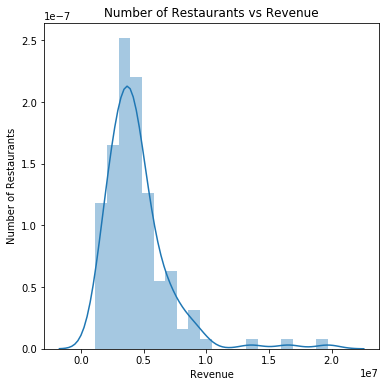

In [7]:
plt.subplots(figsize=(6,6))
sns.distplot(train['revenue'], kde=True, bins=20)
plt.title('Number of Restaurants vs Revenue')
plt.xlabel('Revenue')
plt.ylabel('Number of Restaurants')

Most restaurant generate revenue between 0.25e7 to 0.5e7. Now, let's see how the city affects the restaurant's revenue,

In [8]:
train['City'].nunique()

34

Text(0, 0.5, 'No of restaurants')

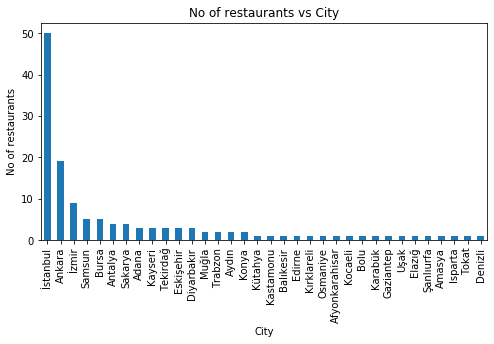

In [9]:
plt.subplots(figsize=(8,4))
train['City'].value_counts().plot(kind='bar')
plt.title('No of restaurants vs City')
plt.xlabel('City')
plt.ylabel('No of restaurants')

1. Istanbul has the maximum number of restaurants.
2. Second is Ankara and then Izimir.
3. Rest of the cities has less than 10 restaurants.

Text(0, 0.5, 'Mean Revenue Generated')

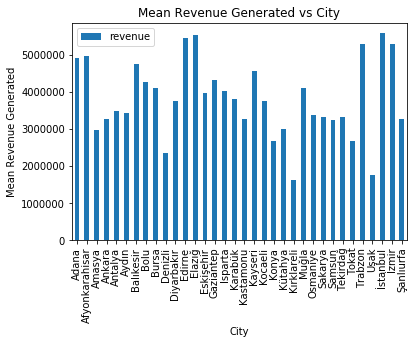

In [10]:
train[['City','revenue']].groupby('City').mean().plot(kind='bar')
plt.title('Mean Revenue Generated vs City')
plt.xlabel('City')
plt.ylabel('Mean Revenue Generated')

Here, 
1. Mean Revenue Generated is over 5M for a few cities.
2. MRG is between 2M to 4M for most cities.
3. It is less than 2M for just 2 cities.

We can't use label encoding on this column,it will mislead the model.We can bin the cities based on Mean Revenue Generated.

Now let's see the CIty Group column.

In [11]:
mean_revenue_per_city = train[['City', 'revenue']].groupby('City', as_index=False).mean()
mean_revenue_per_city['revenue'] = mean_revenue_per_city['revenue'].apply(lambda x: int(x/1e6)) 
mean_revenue_per_city

mean_dict = dict(zip(mean_revenue_per_city.City, mean_revenue_per_city.revenue))
mean_dict

{'Adana': 4,
 'Afyonkarahisar': 4,
 'Amasya': 2,
 'Ankara': 3,
 'Antalya': 3,
 'Aydın': 3,
 'Balıkesir': 4,
 'Bolu': 4,
 'Bursa': 4,
 'Denizli': 2,
 'Diyarbakır': 3,
 'Edirne': 5,
 'Elazığ': 5,
 'Eskişehir': 3,
 'Gaziantep': 4,
 'Isparta': 4,
 'Karabük': 3,
 'Kastamonu': 3,
 'Kayseri': 4,
 'Kocaeli': 3,
 'Konya': 2,
 'Kütahya': 2,
 'Kırklareli': 1,
 'Muğla': 4,
 'Osmaniye': 3,
 'Sakarya': 3,
 'Samsun': 3,
 'Tekirdağ': 3,
 'Tokat': 2,
 'Trabzon': 5,
 'Uşak': 1,
 'İstanbul': 5,
 'İzmir': 5,
 'Şanlıurfa': 3}

In [12]:
train.replace({"City":mean_dict}, inplace=True)
test.replace({"City":mean_dict}, inplace=True)

In [13]:
train['City Group'].unique()

array(['Big Cities', 'Other'], dtype=object)

Text(0.5, 1.0, 'No of Restaurants vs City Group')

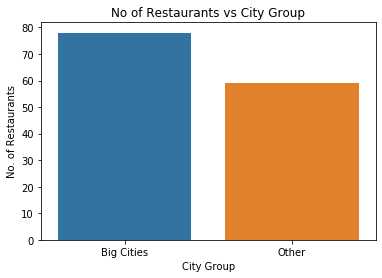

In [14]:
sns.countplot(train['City Group'])
plt.ylabel('No. of Restaurants')
plt.title('No of Restaurants vs City Group')

The number of restaurants located in Big Cities is more.

Text(0.5, 1.0, 'Mean Revenue Generated vs City Group')

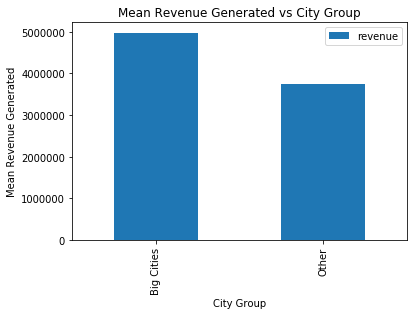

In [15]:
train[['City Group', 'revenue']].groupby('City Group').mean().plot(kind='bar')
plt.ylabel('Mean Revenue Generated')
plt.title('Mean Revenue Generated vs City Group')

Mean revenue generated by restaurants in 'Big Cities' is close to 5M whereas in 'Other' cities it is close to 4M. We can use label encoding on this column.

In [16]:
lr = LabelEncoder()
train['City Group'] = lr.fit_transform(train['City Group'])
test['City Group'] = lr.transform(test['City Group'])

Now the 'Type' column.

In [17]:
train['Type'].unique()

array(['IL', 'FC', 'DT'], dtype=object)

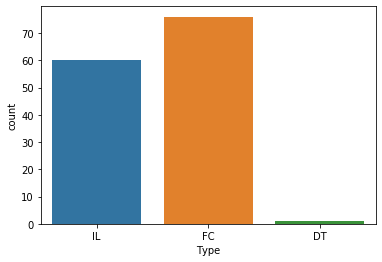

In [18]:
sns.countplot(train['Type'])

Here,
1. We have three types of restaurants, but in the test set another type 'MB' is present. We'll have to fit the label encoder on the test data.

Text(0.5, 1.0, 'Mean Revenue per Type')

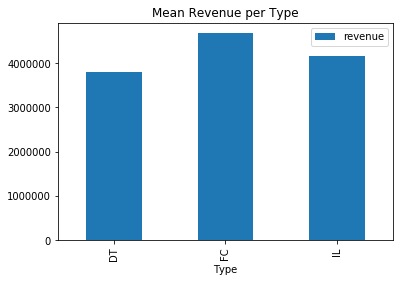

In [19]:
train[['Type', 'revenue']].groupby('Type').mean().plot(kind='bar')
plt.title('Mean Revenue per Type')

In [20]:
test['Type'] = lr.fit_transform(test['Type'])
train['Type'] = lr.transform(train['Type'])

Now, only 'Open Date' categorical column is left. We'll ignore it for now.

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 43 columns):
Id            137 non-null int64
Open Date     137 non-null object
City          137 non-null int64
City Group    137 non-null int64
Type          137 non-null int64
P1            137 non-null int64
P2            137 non-null float64
P3            137 non-null float64
P4            137 non-null float64
P5            137 non-null int64
P6            137 non-null int64
P7            137 non-null int64
P8            137 non-null int64
P9            137 non-null int64
P10           137 non-null int64
P11           137 non-null int64
P12           137 non-null int64
P13           137 non-null float64
P14           137 non-null int64
P15           137 non-null int64
P16           137 non-null int64
P17           137 non-null int64
P18           137 non-null int64
P19           137 non-null int64
P20           137 non-null int64
P21           137 non-null int64
P22           137 non-null i

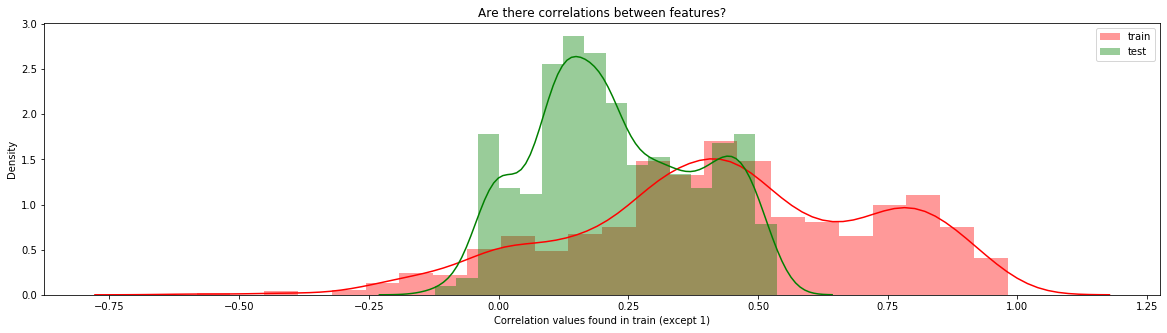

In [22]:
train_correlations = train.drop(["revenue"], axis=1).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Red", label="train")
sns.distplot(test_correlations, color="Green", label="test")
plt.xlabel("Correlation values found in train (except 1)")
plt.ylabel("Density")
plt.title("Are there correlations between features?"); 
plt.legend();

Features in train dataset are highly correlated as compared to the test set. Let's create a baseline and check the most important features using Permutation Importance.

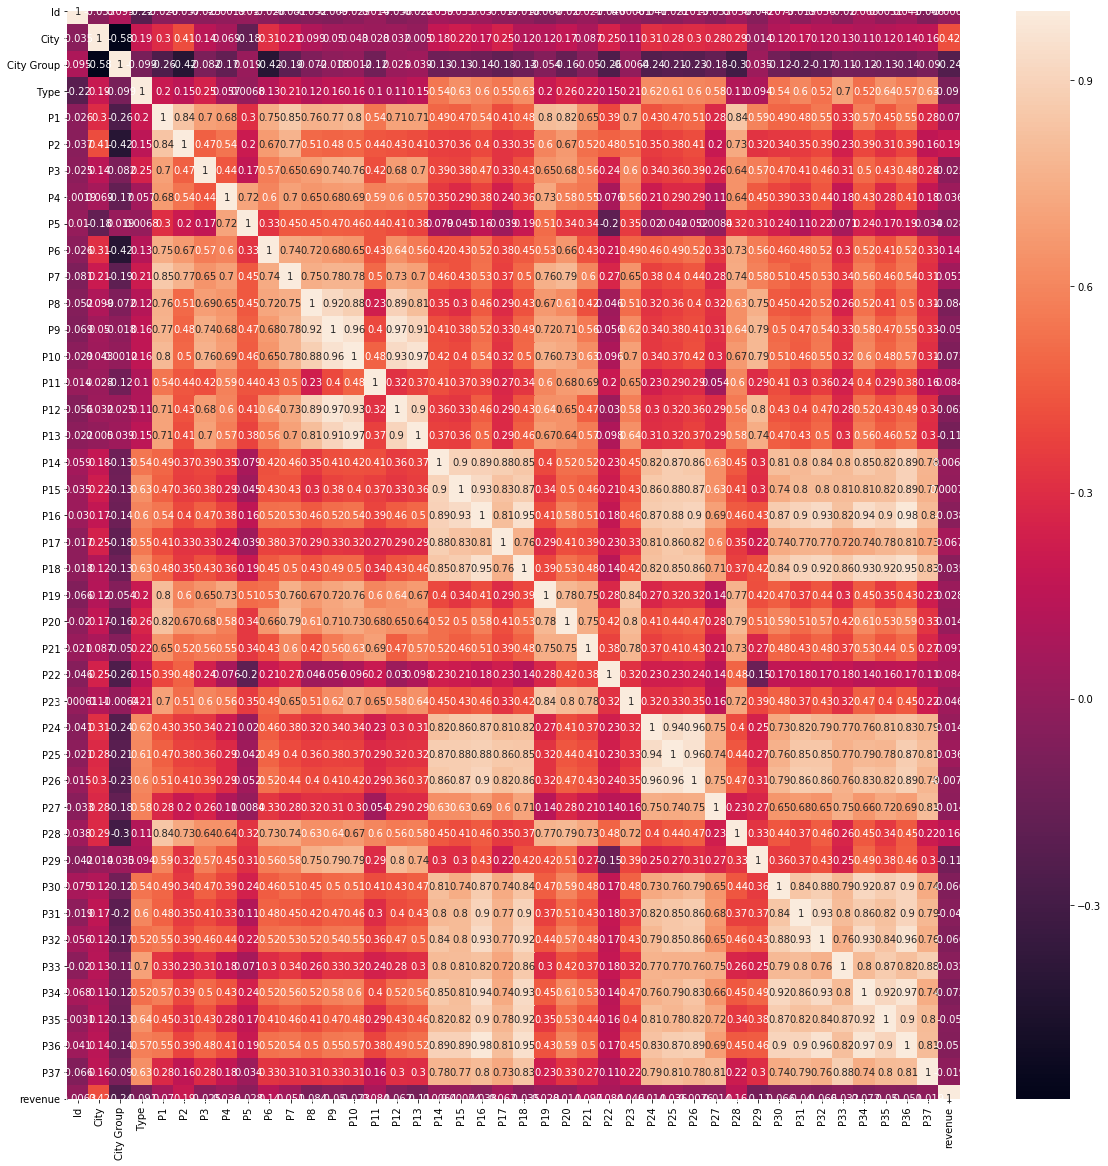

In [23]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(), annot=True)

In [24]:
X = train.drop(['revenue', 'Id', 'Open Date'],axis=1)
y = train['revenue']

In [25]:
X.head()

,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,5,0,2,4,5.0,4.0,4.0,2,2,5,...,2.0,3.0,5,3,4,5,5,4,3,4
1,3,0,1,4,5.0,4.0,4.0,1,2,5,...,3.0,3.0,0,0,0,0,0,0,0,0
2,3,1,2,2,4.0,2.0,5.0,2,3,5,...,1.0,3.0,0,0,0,0,0,0,0,0
3,2,1,2,6,4.5,6.0,6.0,4,4,10,...,2.5,7.5,25,12,10,6,18,12,12,6
4,4,1,2,3,4.0,3.0,4.0,2,2,5,...,1.0,3.0,5,1,3,2,3,4,3,3


In [26]:
model = LinearRegression(normalize=True)
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [27]:
perm = PermutationImportance(model, random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names = X.columns.to_list())

Weight,Feature
3.2115 ± 0.5637,P26
2.6837 ± 0.4652,P9
2.1037 ± 0.1821,P16
1.3928 ± 0.1881,P36
1.2282 ± 0.3889,P8
0.9201 ± 0.2810,P18
0.5851 ± 0.1453,City
0.5305 ± 0.1282,P20
0.4461 ± 0.1216,P10
0.3984 ± 0.0960,P28


The values towards the top are the most important features, and those towards the bottom matter least. P26, P9, P16, P36, P8, P18 and City are important features. Now, let's plot their graphs.

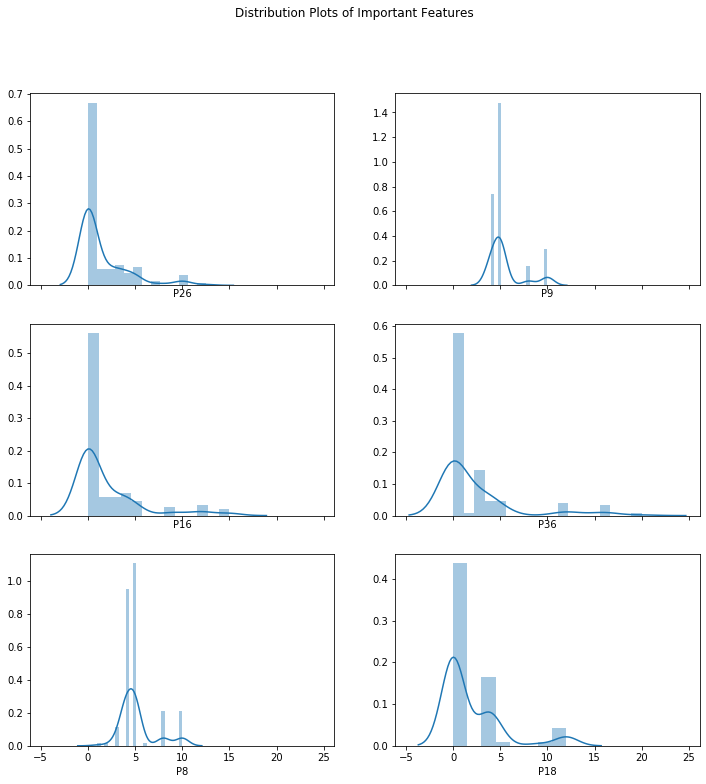

In [28]:
important_features = ['P26', 'P9', 'P16', 'P36', 'P8', 'P18']

f, axes = plt.subplots(3,2, figsize=(12,12), sharex=True)
f.suptitle('Distribution Plots of Important Features')

for ax,feature in zip(axes.flatten(), important_features):
    sns.distplot(X[feature], ax=ax)

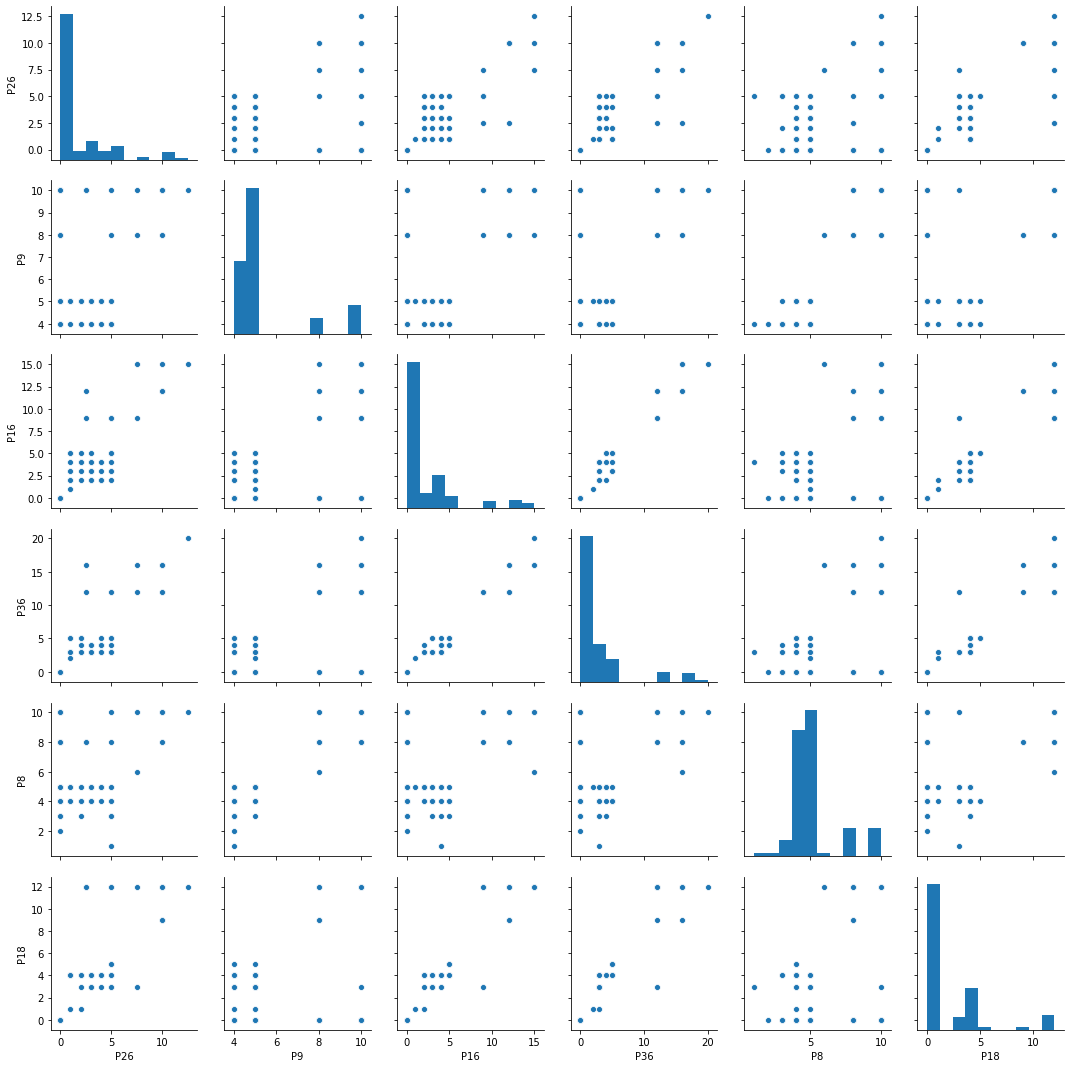

In [29]:
sns.pairplot(train[important_features])

## Baseline Submission

In [44]:
cv = KFold(n_splits=10, shuffle=True, random_state=108)
model = XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.01)

scores = []
for train_idx, test_idx in cv.split(X):
    X_train = X.iloc[train_idx]
    X_val = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_val = y.iloc[test_idx]
    
    model.fit(X_train,y_train)
    preds = model.predict(X_val)
    
    rmse = sqrt(mean_squared_error(y_val, preds))
    print(rmse)
    scores.append(rmse)

print("\nMean score %d"%np.mean(scores))

2108380.1867518625
4371374.797056307
1925946.9921925804
684451.3529539
2136886.5621601613
3311328.139783443
2048834.313035689
1878097.4106345847
2180385.1722643347
3083035.3979175016

Mean score 2372872


In [45]:
test.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,01/22/2011,6,1,1,1,4.0,4.0,4.0,1,...,2.0,3.0,0,0,0,0,0,0,0,0
1,1,03/18/2011,2,1,2,3,4.0,4.0,4.0,2,...,1.0,3.0,0,0,0,0,0,0,0,0
2,2,10/30/2013,3,0,1,3,4.0,4.0,4.0,2,...,2.0,3.0,0,0,0,0,0,0,0,0
3,3,05/06/2013,3,1,2,2,4.0,4.0,4.0,2,...,2.0,3.0,0,4,0,0,0,0,0,0
4,4,07/31/2013,4,1,1,2,4.0,4.0,4.0,1,...,5.0,3.0,0,0,0,0,0,0,0,0


In [32]:
test.City.unique()

array(['Niğde', 2, 3, 4, 'Rize', 5, 'Düzce', 'Hatay', 'Erzurum', 'Mersin',
       'Zonguldak', 'Malatya', 'Çanakkale', 'Kars', 'Batman', 'Bilecik',
       'Giresun', 'Sivas', 'Kırıkkale', 'Mardin', 'Erzincan', 'Manisa',
       'Kahramanmaraş', 'Yalova', 'Tanımsız', 'Kırşehir', 'Aksaray',
       'Nevşehir', 'Çorum', 'Ordu', 1, 'Artvin', 'Siirt', 'Çankırı'],
      dtype=object)

There are new cities in the test set. For now let's give all of them number 6.

In [33]:
test['City'] = test['City'].apply(lambda x: 6 if isinstance(x,str) else x)

In [46]:
predictions = model.predict(test.drop(['Id', 'Open Date'], axis=1))
sample['Prediction'] = predictions

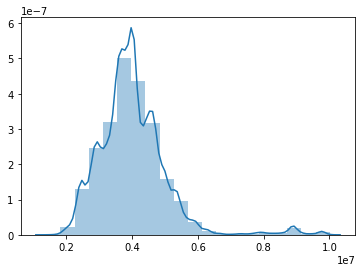

In [47]:
sns.distplot(predictions, bins=20)

In [48]:
sample.to_csv('submission.csv', index=False)